<a href="https://colab.research.google.com/github/OmerRosen/DifferentProjects/blob/main/Spotify_Detector_Data_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<b>Project: Hit or miss</b><br>
<br>
Predicting whether a Spotify song is a flop or a hit.

In [ ]:
!pip install progressbar

In [ ]:
!pip install gender_guesser

In [ ]:
import os
import math
import warnings

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

import requests
from bs4 import BeautifulSoup 
import re
import time
import progressbar

from sklearn.model_selection import cross_val_score, train_test_split,cross_validate
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve,auc


import seaborn as sns


<br><b>Loading The Data</b><br>
Since our data set is comprised of 6 different csv files (A file for each decade), we will iterate over them and combine them, while using the decade as an additional feature.

In [ ]:

warnings.filterwarnings('ignore')

baseFilePath = "data"
list_of_files = os.listdir(baseFilePath)
first_run = True
for file in list_of_files:
    if '.csv' in file:
        full_path = os.path.join(baseFilePath,file)
        print(f"Found matching file: {full_path}")
        fileDecade = file[-7:-5]
        
        
        df = pd.read_csv(full_path)
        if fileDecade in ('00','10'):
            decade_year=int('20'+fileDecade)
        else:
            decade_year=int('19'+fileDecade)
        
        df['decade']=decade_year
        print(f"Decade: {decade_year}. Num Of Records: {df.shape[0]}\n")   
        
        
        if first_run:
            data = df
            first_run = False
        else:
            data = data.append(df, ignore_index=True)
        
        
print(f"Total Number of {data.shape[0]} records with {data.shape[1]} different columns")

Found matching file: data\dataset-of-00s.csv
Decade: 2000. Num Of Records: 5872

Found matching file: data\dataset-of-10s.csv
Decade: 2010. Num Of Records: 6398

Found matching file: data\dataset-of-60s.csv
Decade: 1960. Num Of Records: 8642

Found matching file: data\dataset-of-70s.csv
Decade: 1970. Num Of Records: 7766

Found matching file: data\dataset-of-80s.csv
Decade: 1980. Num Of Records: 6908

Found matching file: data\dataset-of-90s.csv
Decade: 1990. Num Of Records: 5520

Total Number of 41106 records with 20 different columns


<br><b>Adding External Data</b><br>
To improve prediction accuracy, we will use the uri in order to scrape Spotify and extract additional information about the artist:

In order to avoid multiple Spotify scrapping, we will perform the scrapping in batches, and save the output with the new gender details each time so that we will not lose our data

In [ ]:
use_premade_dataset = True

premade_file_path = "dataset_with_gender.csv"

if not os.path.exists(premade_file_path):
    use_premade_dataset = False
    premade_dataset = data.copy()
    premade_dataset['artist_gender'] = None
    premade_dataset.to_csv(path_or_buf=premade_file_path, index_label='index')
    print(f"No file found, will create a new file and save it to: {premade_file_path}")
else:
    premade_dataset = pd.read_csv(premade_file_path, index_col='index')
    print(f"Loaded file from: {premade_file_path}")
    
is_gender_na = premade_dataset['artist_gender'].isna()
print(f"Total Records: {premade_dataset.shape[0]}. With Gender: {premade_dataset[is_gender_na==False].shape[0]}. Without Gender: {premade_dataset[is_gender_na].shape[0]}")

Loaded file from: dataset_with_gender.csv
Total Records: 41106. With Gender: 520. Without Gender: 40586


In [ ]:
premade_dataset.to_csv(path_or_buf=premade_file_path, index_label='index')
premade_dataset.head(5)

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,...,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,decade,artist_gender
index,,,,,,,,,,,,,,,,,,,,,
0,Lucky Man,Montgomery Gentry,spotify:track:4GiXBCUF7H6YfNQsnBRIzl,0.578,0.471,4,-7.270,1,0.0289,0.368000,...,0.159,0.532,133.061,196707,4,30.88059,13,1,2000,Band
1,On The Hotline,Pretty Ricky,spotify:track:1zyqZONW985Cs4osz9wlsu,0.704,0.854,10,-5.477,0,0.1830,0.018500,...,0.148,0.688,92.988,242587,4,41.51106,10,1,2000,Male
2,Clouds Of Dementia,Candlemass,spotify:track:6cHZf7RbxXCKwEkgAZT4mY,0.162,0.836,9,-3.009,1,0.0473,0.000111,...,0.174,0.300,86.964,338893,4,65.32887,13,0,2000,Male
3,"Heavy Metal, Raise Hell!",Zwartketterij,spotify:track:2IjBPp2vMeX7LggzRN3iSX,0.188,0.994,4,-3.745,1,0.1660,0.000007,...,0.192,0.333,148.440,255667,4,58.59528,9,0,2000,Male
4,I Got A Feelin',Billy Currington,spotify:track:1tF370eYXUcWwkIvaq3IGz,0.630,0.764,2,-4.353,1,0.0275,0.363000,...,0.125,0.631,112.098,193760,4,22.62384,10,1,2000,Male


<br><b>Observing The Data</b><br>
We will go over our different columns, make note of their scales and divide them into columns types for later preprocessing.

In [ ]:
data.head(5)

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,decade
0,Lucky Man,Montgomery Gentry,spotify:track:4GiXBCUF7H6YfNQsnBRIzl,0.578,0.471,4,-7.270,1,0.0289,0.368000,0.00000,0.159,0.532,133.061,196707,4,30.88059,13,1,2000
1,On The Hotline,Pretty Ricky,spotify:track:1zyqZONW985Cs4osz9wlsu,0.704,0.854,10,-5.477,0,0.1830,0.018500,0.00000,0.148,0.688,92.988,242587,4,41.51106,10,1,2000
2,Clouds Of Dementia,Candlemass,spotify:track:6cHZf7RbxXCKwEkgAZT4mY,0.162,0.836,9,-3.009,1,0.0473,0.000111,0.00457,0.174,0.300,86.964,338893,4,65.32887,13,0,2000
3,"Heavy Metal, Raise Hell!",Zwartketterij,spotify:track:2IjBPp2vMeX7LggzRN3iSX,0.188,0.994,4,-3.745,1,0.1660,0.000007,0.07840,0.192,0.333,148.440,255667,4,58.59528,9,0,2000
4,I Got A Feelin',Billy Currington,spotify:track:1tF370eYXUcWwkIvaq3IGz,0.630,0.764,2,-4.353,1,0.0275,0.363000,0.00000,0.125,0.631,112.098,193760,4,22.62384,10,1,2000


In [ ]:
data.describe().round(3)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,decade
count,41106.000,41106.000,41106.000,41106.000,41106.000,41106.000,41106.000,41106.000,41106.000,41106.000,41106.000,41106.000,41106.000,41106.000,41106.000,41106.0,41106.000
mean,0.540,0.580,5.214,-10.222,0.693,0.073,0.364,0.154,0.202,0.542,119.338,234877.550,3.894,40.106,10.476,0.5,1982.775
std,0.178,0.253,3.535,5.312,0.461,0.086,0.339,0.304,0.173,0.267,29.099,118967.398,0.423,19.006,4.872,0.5,17.491
min,0.000,0.000,0.000,-49.253,0.000,0.000,0.000,0.000,0.013,0.000,0.000,15168.000,0.000,0.000,0.000,0.0,1960.000
25%,0.420,0.396,2.000,-12.816,0.000,0.034,0.039,0.000,0.094,0.330,97.397,172927.750,4.000,27.600,8.000,0.0,1970.000
50%,0.552,0.601,5.000,-9.257,1.000,0.043,0.258,0.000,0.132,0.558,117.565,217907.000,4.000,35.851,10.000,0.5,1980.000
75%,0.669,0.787,8.000,-6.374,1.000,0.070,0.676,0.061,0.261,0.768,136.494,266773.000,4.000,47.626,12.000,1.0,2000.000
max,0.988,1.000,11.000,3.744,1.000,0.960,0.996,1.000,0.999,0.996,241.423,4170227.000,5.000,433.182,169.000,1.0,2010.000


<br><b>Find Categorical Data:</b><br>
Look for a column with less than 20 unique values.<br>

In [ ]:
for col in data.columns:
    print(f"Column: {col}.    Unique Values: {len(data[col].unique())}")
    if len(data[col].unique())<20:
        print(f"           This is a categorical type column with {len(data[col].unique())} unique values:\n            {data[col].unique()}")

Column: track.    Unique Values: 35860
Column: artist.    Unique Values: 11904
Column: uri.    Unique Values: 40560
Column: danceability.    Unique Values: 1048
Column: energy.    Unique Values: 1787
Column: key.    Unique Values: 12
           This is a categorical type column with 12 unique values:
            [ 4 10  9  2 11  1  7  8  0  3  5  6]
Column: loudness.    Unique Values: 16160
Column: mode.    Unique Values: 2
           This is a categorical type column with 2 unique values:
            [1 0]
Column: speechiness.    Unique Values: 1346
Column: acousticness.    Unique Values: 4194
Column: instrumentalness.    Unique Values: 5122
Column: liveness.    Unique Values: 1674
Column: valence.    Unique Values: 1609
Column: tempo.    Unique Values: 32152
Column: duration_ms.    Unique Values: 21517
Column: time_signature.    Unique Values: 5
           This is a categorical type column with 5 unique values:
            [4 3 1 5 0]
Column: chorus_hit.    Unique Values: 39950
Colum

<br>Upon looking at our data we can split it into the following types:<br>
1. Textual Columns - We will not be able to use them as they appear currently and they will be dropped for now.<br>
2. Numerical Columns - We will need to scale these later on.
3. Categorical Columns - We will need to convert these using One-Hot-Encoding.
4. Binary Columns
5. Result Column - This contain our Y values

In [ ]:
columns_to_drop = ['track','artist','uri']
categorical_columns = ['key','time_signature','decade']
binary_columns = ['mode']
numerical_columns = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'chorus_hit','sections']
y_column = ['target']

predictor_columns = categorical_columns + binary_columns + numerical_columns
print(f"Our Dataset have: \n  {len(categorical_columns)} categorical_columns. \n  {len(binary_columns)} binary_columns. \n  {len(numerical_columns)} numerical_columns. \n  Total: {len(predictor_columns)} predictor_columns.")

Our Dataset have: 
  3 categorical_columns. 
  1 binary_columns. 
  12 numerical_columns. 
  Total: 16 predictor_columns.


In [ ]:
X = data[predictor_columns].copy()
y = data['target']

<br><b>Data Balance</b><br>
We will observe the ratio in our y values, in addition to our categorical and binary columns, and observe if there is an imbalance that requires intervention.


In [ ]:
print(f"Flops Count: {y.value_counts()[0]} \nHits  Count: {y.value_counts()[1]}")

Flops Count: 20553 
Hits  Count: 20553


An interesting find we have here is regarding our Y label, which is perfectly balanced<br>
This isn't necessarily a positive thing since it means that the data was most likely collected with the intent of finding equal amount of Hits and Flops<br>
This can indicate a potential bias in the data collection (e.g - 20,553 is ALL the hits from the past 6 decades, while 20,553 flops is just a small sample from an endless population of flops) <br>

<br>Next, we will look at the categorical and binary data distribution and try to find imbalances. <br><br>
There also appear to be an imbalance with the majority of our categorical data, the most notable being time_signature with a high frequency of value 5.<br>
This will need to be re-examined once we build our model and estimate the feature importance.


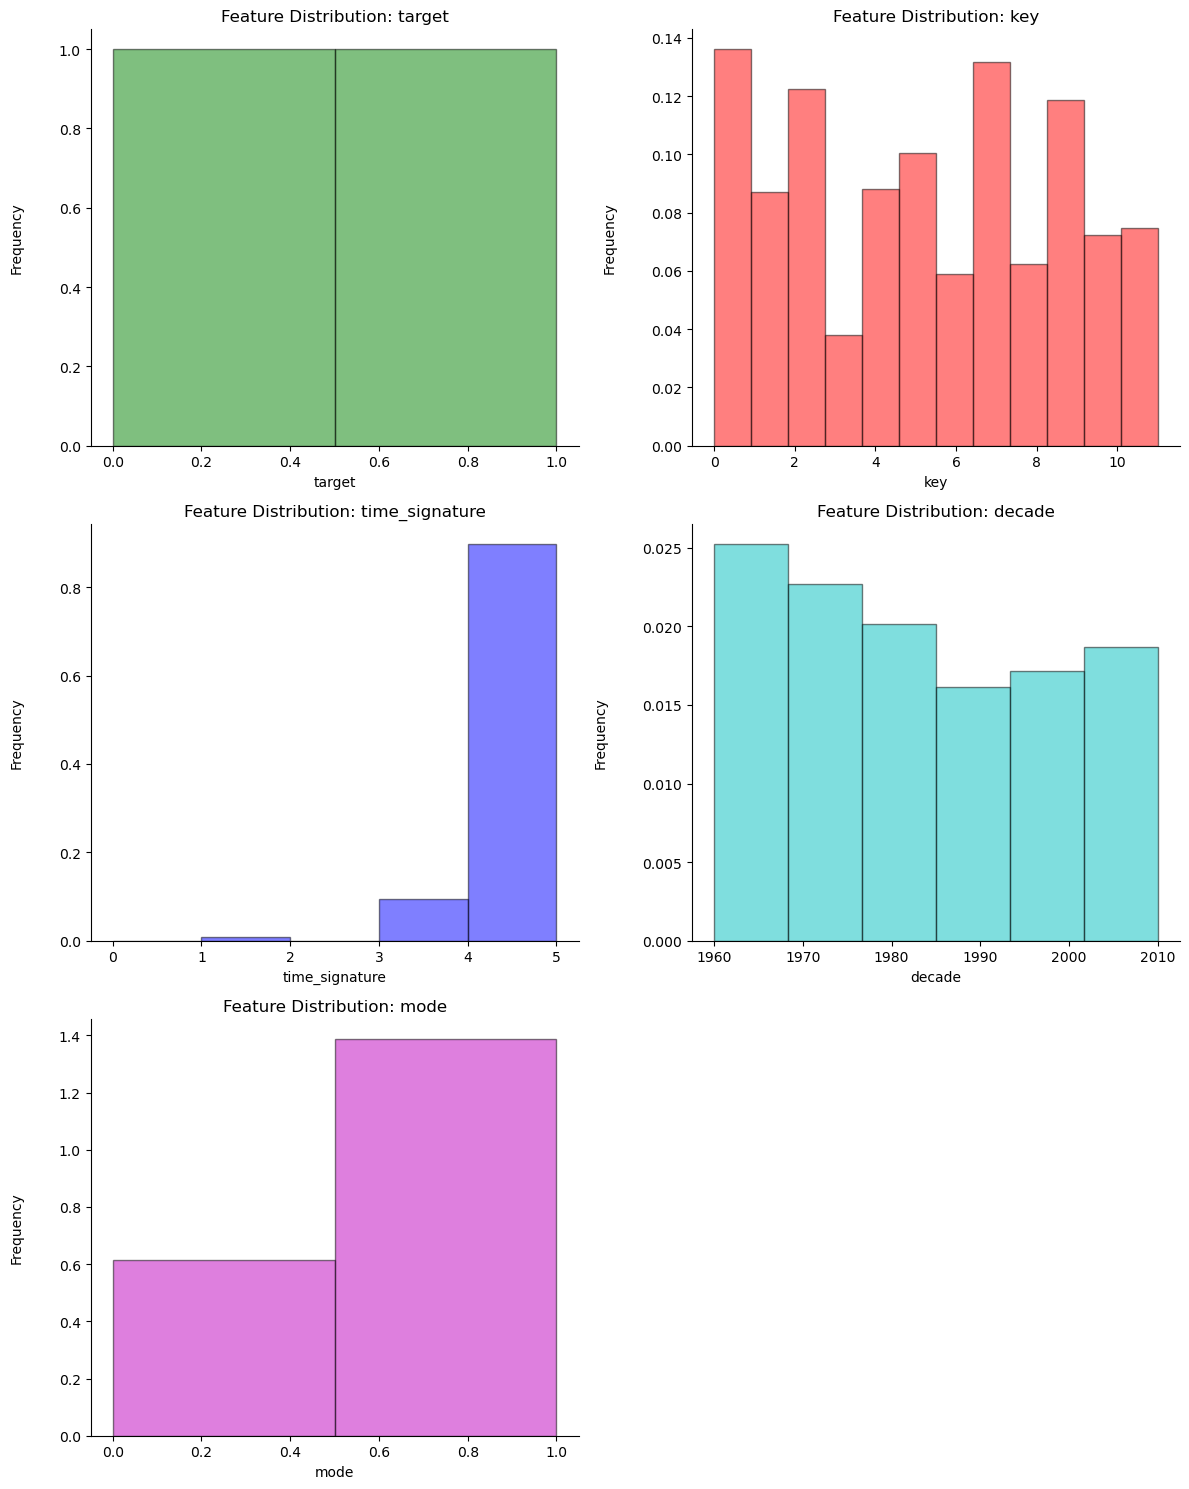

In [ ]:
cols_for_histogram = y_column+categorical_columns +binary_columns
feature_num = len(cols_for_histogram)

plot_per_row = 2
row_num = math.ceil(feature_num/plot_per_row)

fig = plt.gcf()
fig.set_size_inches(12,15)

c_list = ['g','r','b','c','m','y','k','tab:pink']


for i,col in enumerate(cols_for_histogram):
    
    col_vals = data[[col]]
    col_vals_series = data[col]
    unique_vals = len(col_vals_series.unique())
    
    bin_start = min(col_vals.min())
    bin_end = max(col_vals.max())
    bins = np.linspace(bin_start, bin_end, unique_vals+1)
    
    ax = fig.add_subplot(row_num,2,i+1)
    height, bins, patches = ax.hist(col_vals, bins, alpha=0.5, label=f"Feature {col}",density=True,edgecolor='k', color=c_list[i])
    #ax.legend(loc='upper left',fontsize=16)
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency',rotation=90,labelpad=25)
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title(f'Feature Distribution: {col}')

plt.tight_layout()
plt.plot;

<br><b>Predictor Corralation</b><br>
We will observe the relationship between each predictor individually and attempt to see if any noteable correlation are spotted between the feature and whether or not the song is a hit.<br><br>

In the plot below, we can notice some interesting relationships:<br>
1. Dancability - If your song has less than ~0.2 dancability rate you will not become a hit.
2. Loudness - There is a correlation between loudness and success
3. Speechness - If your speech-to-music ration is higher than 0.45 it decreases your odds significantly at having a hit.
4. Duration - The longer your song lasts the fewer people will listen to it again.
5. Sections - The number of sections the particular track has appear to have an effect on its success rate.


In [ ]:
color_map = []
for val in y:
    if val==1:
        color_map.append('g')
    else:
        color_map.append('r')

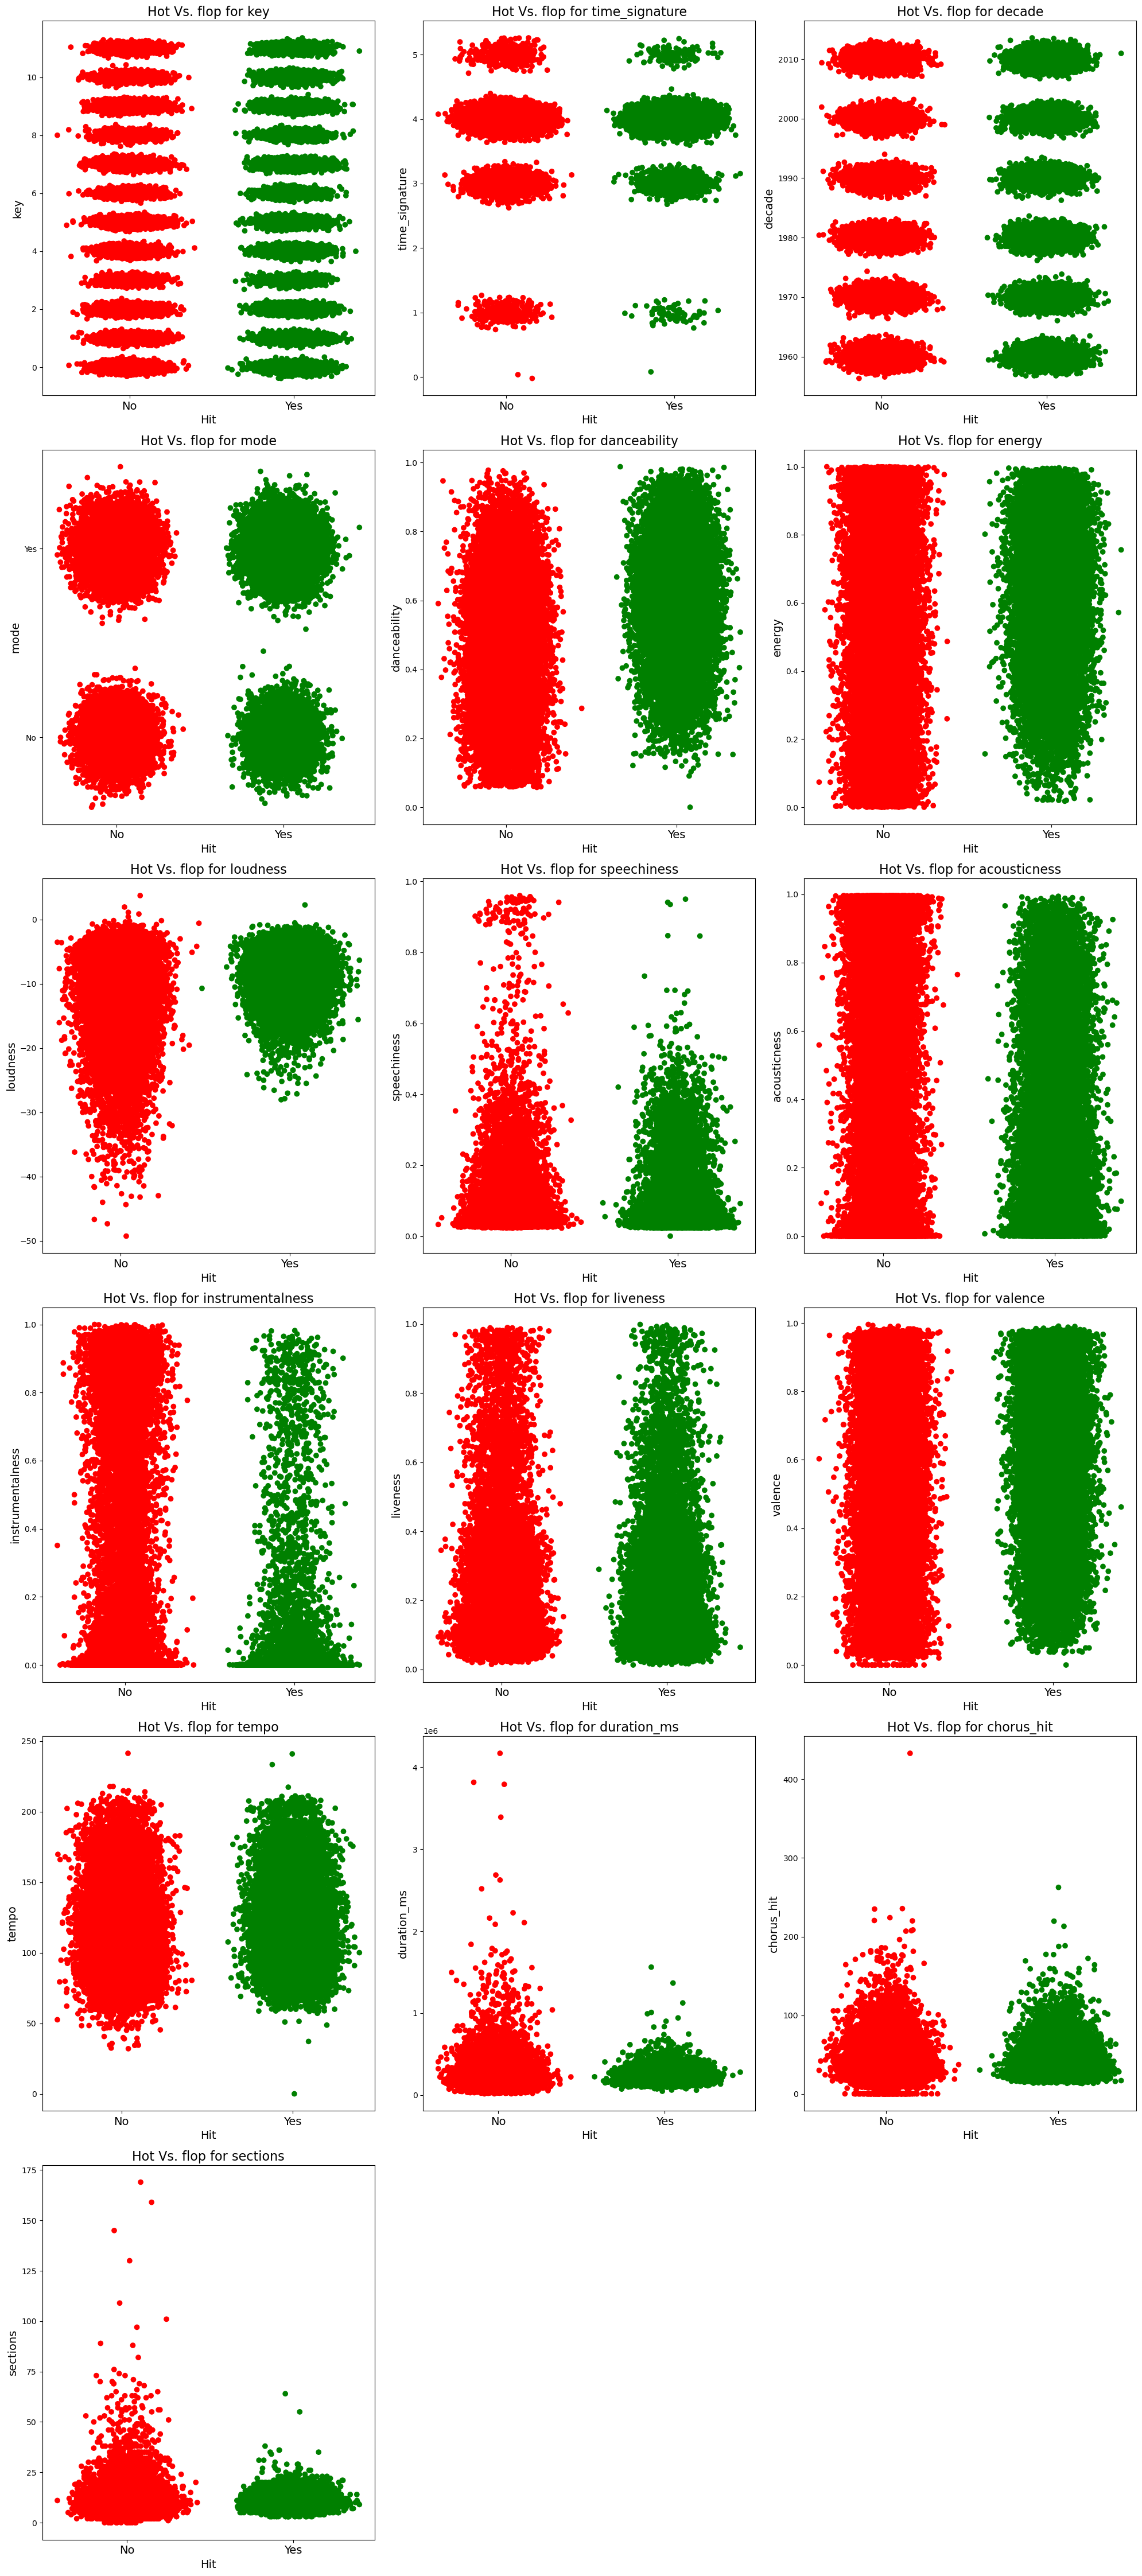

In [ ]:
import math

coeff_num = len(predictor_columns)
plot_col_num = 3
row_num = math.ceil(coeff_num/plot_col_num)

fig = plt.gcf()
fig.set_size_inches(20,45)

for i,values in enumerate(predictor_columns):
    
    sigma = 0.1
    
    mu =0.001
    
    # generate normally distributed samples
    y_noise = sigma * np.random.randn(X.shape[0]) + mu
    
    ax = fig.add_subplot(row_num,plot_col_num,i+1)
    x_val = X[values]
    if values in binary_columns:
        x_noise = sigma * np.random.randn(X.shape[0]) + mu
        x_val = X[values]+x_noise
        ax.set_yticks((0,1), labels=('No', 'Yes'))
        
    if values in categorical_columns:
        if values=="decade": # Decade is set in jumps of 10 rather than 1
            sigma = sigma*10 
        x_noise = sigma * np.random.randn(X.shape[0]) + mu
        x_val = X[values]+x_noise
        #ax.set_yticks(range(len(X[values].unique())), labels=(X[values].unique()))
    
    ax.scatter(y+y_noise,x_val, color=color_map)
    ax.set_ylabel(f'{values}', fontsize=14)
    ax.set_xlabel('Hit', fontsize=14)
    ax.set_xticks((0,1), labels=('No', 'Yes'), fontsize=14)
    ax = plt.gca()
    ax.set_title(f'Hot Vs. flop for {values}').set_size(16)

    
plt.tight_layout()
plt.plot;

<br><b>Data Preprocessing:</b><br>
We will cover the following steps:<br>
1. Look for NaN values.<br>
2. One hot Encode.<br>
3. Split Train-Test.<br>
4. Scale Data (From train to test).<br>

<br><b>Missing Data</b><br>
Luckly our dataset was built without missing data, which makes our data processing much easier.<br><br>
Should any data have been missing, we would have tried to speculate whether it was Missing completely at random (MCAR),  Missing at random (MAR) or Missing not at random (MNAR)<br><br>
Based on our estimation we would then either fill the data at random or use methods such as K-NN Imputation

In [ ]:
for i,col in enumerate(X.columns):
    num_of_missing_vals = X[col].isna().sum()
    print(f"{i} {col} - num_of_missing_vals: {num_of_missing_vals}")

0 key - num_of_missing_vals: 0
1 time_signature - num_of_missing_vals: 0
2 decade - num_of_missing_vals: 0
3 mode - num_of_missing_vals: 0
4 danceability - num_of_missing_vals: 0
5 energy - num_of_missing_vals: 0
6 loudness - num_of_missing_vals: 0
7 speechiness - num_of_missing_vals: 0
8 acousticness - num_of_missing_vals: 0
9 instrumentalness - num_of_missing_vals: 0
10 liveness - num_of_missing_vals: 0
11 valence - num_of_missing_vals: 0
12 tempo - num_of_missing_vals: 0
13 duration_ms - num_of_missing_vals: 0
14 chorus_hit - num_of_missing_vals: 0
15 sections - num_of_missing_vals: 0


<br><b>Remove non-music:</b><br>
Per Kaggle, any datapoint above 0.66 speechness ration is not considered a song, but rather a podcast or lecture.<br>
As such, we would like to filter these out<br>

In [ ]:
print(f"Number Of records before: {X.shape[0]}")
records_to_keep = X['speechiness']<=0.66
X = X[records_to_keep]
y_trimmed = []
for i,rec in enumerate(records_to_keep):
    if rec==True:
        y_trimmed.append(y[i])
    
y = pd.Series(y_trimmed)
print(f"Number Of records after: {X.shape[0]}")
print(f"Records dropped: {X.shape[0]}")

Number Of records before: 41106
Number Of records after: 40965
Records dropped: 40965


<br><b>One Hot Encoding</b><br>
We will convert all of our categorical columns into binary columns.

In [ ]:
for i,col in enumerate(categorical_columns):
    onehot = pd.get_dummies(X[col], prefix=col)
    if i==0:
        X_ohe = X.join(onehot)
    else:
        X_ohe = X_ohe.join(onehot)
    X_ohe = X_ohe.drop([col], axis=1)
    print(f"Col {col} - Converted into {onehot.shape[1]} hot-encoded columns")
X_ohe

Col key - Converted into 12 hot-encoded columns
Col time_signature - Converted into 5 hot-encoded columns
Col decade - Converted into 6 hot-encoded columns


,mode,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,...,time_signature_1,time_signature_3,time_signature_4,time_signature_5,decade_1960,decade_1970,decade_1980,decade_1990,decade_2000,decade_2010
0,1,0.578,0.471,-7.270,0.0289,0.368000,0.000000,0.1590,0.532,133.061,...,0,0,1,0,0,0,0,0,1,0
1,0,0.704,0.854,-5.477,0.1830,0.018500,0.000000,0.1480,0.688,92.988,...,0,0,1,0,0,0,0,0,1,0
2,1,0.162,0.836,-3.009,0.0473,0.000111,0.004570,0.1740,0.300,86.964,...,0,0,1,0,0,0,0,0,1,0
3,1,0.188,0.994,-3.745,0.1660,0.000007,0.078400,0.1920,0.333,148.440,...,0,0,1,0,0,0,0,0,1,0
4,1,0.630,0.764,-4.353,0.0275,0.363000,0.000000,0.1250,0.631,112.098,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41101,0,0.396,0.795,-6.070,0.2340,0.000928,0.000209,0.1820,0.762,152.943,...,0,0,1,0,0,0,0,1,0,0
41102,0,0.621,0.655,-6.281,0.0309,0.050600,0.006260,0.0937,0.690,134.167,...,0,0,1,0,0,0,0,1,0,0
41103,0,0.562,0.314,-15.213,0.0298,0.440000,0.000011,0.1060,0.571,166.847,...,0,0,1,0,0,0,0,1,0,0
41104,1,0.622,0.781,-6.080,0.0368,0.000101,0.755000,0.3830,0.214,120.051,...,0,0,1,0,0,0,0,1,0,0


<br><b>Feature Correlation</b><br>
We will check to see if there is any high correlation within our features.<br>
If the correlation is too high, we will drop one of the features.

In [ ]:
X_ohe[numerical_columns].corr()

,danceability,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,chorus_hit
danceability,1.000000,0.279117,0.166082,-0.264460,-0.301223,-0.116284,0.555219,-0.065110,-0.062123,-0.035979
loudness,0.279117,1.000000,0.140109,-0.565070,-0.378581,0.092110,0.271522,0.167547,-0.053121,-0.013816
speechiness,0.166082,0.140109,1.000000,-0.142533,-0.084267,0.123368,0.015938,0.063031,0.017567,0.017869
acousticness,-0.264460,-0.565070,-0.142533,1.000000,0.206422,-0.034670,-0.194928,-0.178662,-0.070410,-0.012307
instrumentalness,-0.301223,-0.378581,-0.084267,0.206422,1.000000,-0.049705,-0.287714,-0.054680,0.106503,0.048609
liveness,-0.116284,0.092110,0.123368,-0.034670,-0.049705,1.000000,0.002039,0.026335,0.005445,0.037525
valence,0.555219,0.271522,0.015938,-0.194928,-0.287714,0.002039,1.000000,0.107634,-0.174127,-0.059376
tempo,-0.065110,0.167547,0.063031,-0.178662,-0.054680,0.026335,0.107634,1.000000,-0.024326,-0.056755
duration_ms,-0.062123,-0.053121,0.017567,-0.070410,0.106503,0.005445,-0.174127,-0.024326,1.000000,0.093485
chorus_hit,-0.035979,-0.013816,0.017869,-0.012307,0.048609,0.037525,-0.059376,-0.056755,0.093485,1.000000


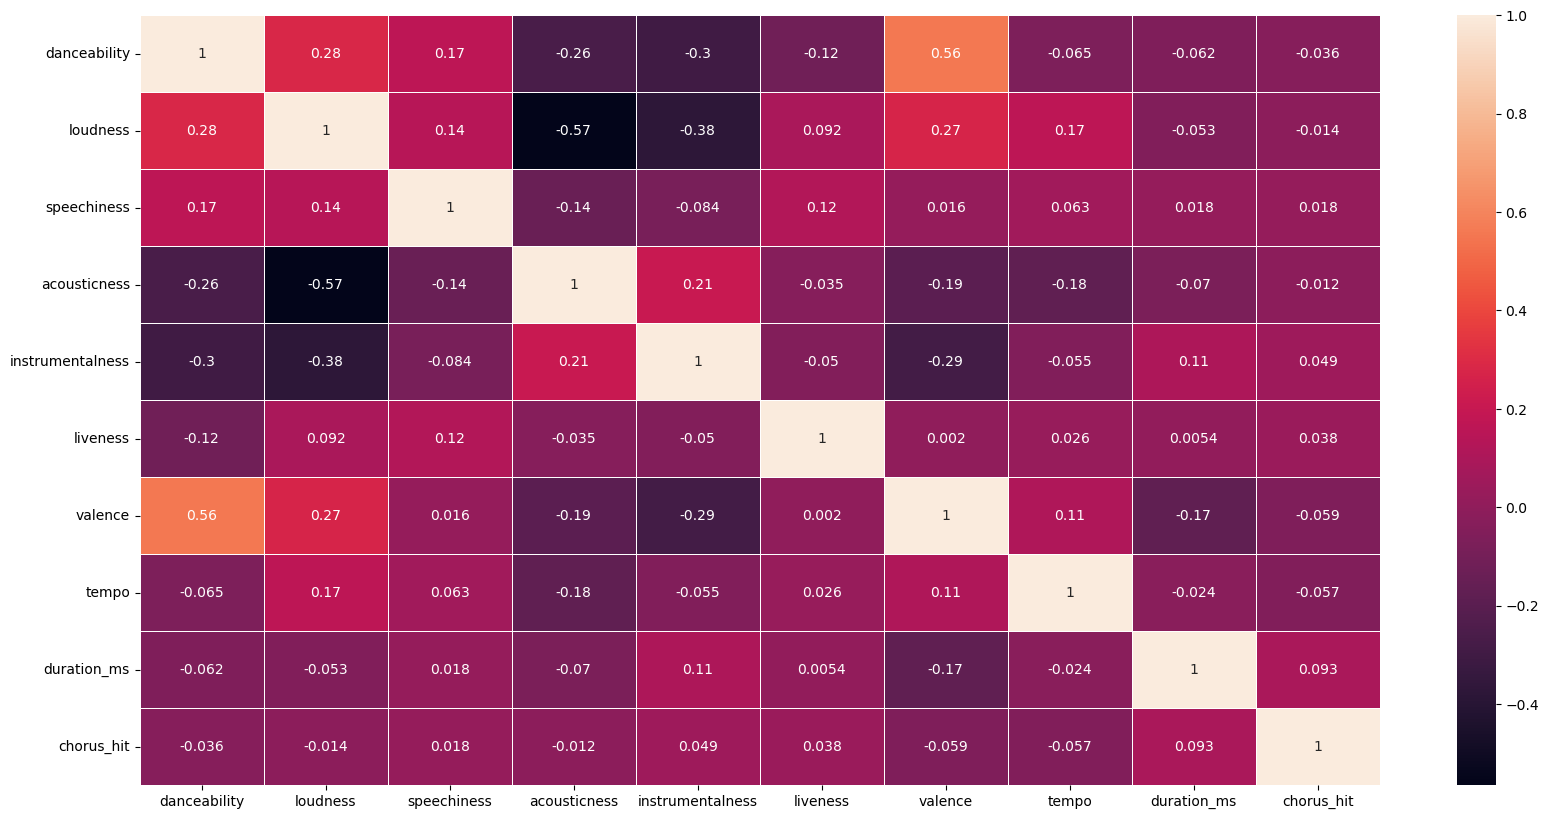

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
dataplot = sns.heatmap(X_ohe[numerical_columns].corr(), annot=True, linewidths=0.5, ax=ax)

In [ ]:
features_to_drop = ['sections','energy']
X_ohe.drop(columns=features_to_drop,inplace=True)
X_ohe

,mode,danceability,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,...,time_signature_1,time_signature_3,time_signature_4,time_signature_5,decade_1960,decade_1970,decade_1980,decade_1990,decade_2000,decade_2010
0,1,0.578,-7.270,0.0289,0.368000,0.000000,0.1590,0.532,133.061,196707,...,0,0,1,0,0,0,0,0,1,0
1,0,0.704,-5.477,0.1830,0.018500,0.000000,0.1480,0.688,92.988,242587,...,0,0,1,0,0,0,0,0,1,0
2,1,0.162,-3.009,0.0473,0.000111,0.004570,0.1740,0.300,86.964,338893,...,0,0,1,0,0,0,0,0,1,0
3,1,0.188,-3.745,0.1660,0.000007,0.078400,0.1920,0.333,148.440,255667,...,0,0,1,0,0,0,0,0,1,0
4,1,0.630,-4.353,0.0275,0.363000,0.000000,0.1250,0.631,112.098,193760,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41101,0,0.396,-6.070,0.2340,0.000928,0.000209,0.1820,0.762,152.943,82107,...,0,0,1,0,0,0,0,1,0,0
41102,0,0.621,-6.281,0.0309,0.050600,0.006260,0.0937,0.690,134.167,211653,...,0,0,1,0,0,0,0,1,0,0
41103,0,0.562,-15.213,0.0298,0.440000,0.000011,0.1060,0.571,166.847,189827,...,0,0,1,0,0,0,0,1,0,0
41104,1,0.622,-6.080,0.0368,0.000101,0.755000,0.3830,0.214,120.051,330053,...,0,0,1,0,0,0,0,1,0,0


Update the numerical_columns list accordingly without the dropped features

In [ ]:
numerical_columns = [col for col in numerical_columns if col not in features_to_drop]
numerical_columns

['danceability',
 'loudness',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'duration_ms',
 'chorus_hit']

Re-examine the feature to confirm that all high correlations have been eliminated

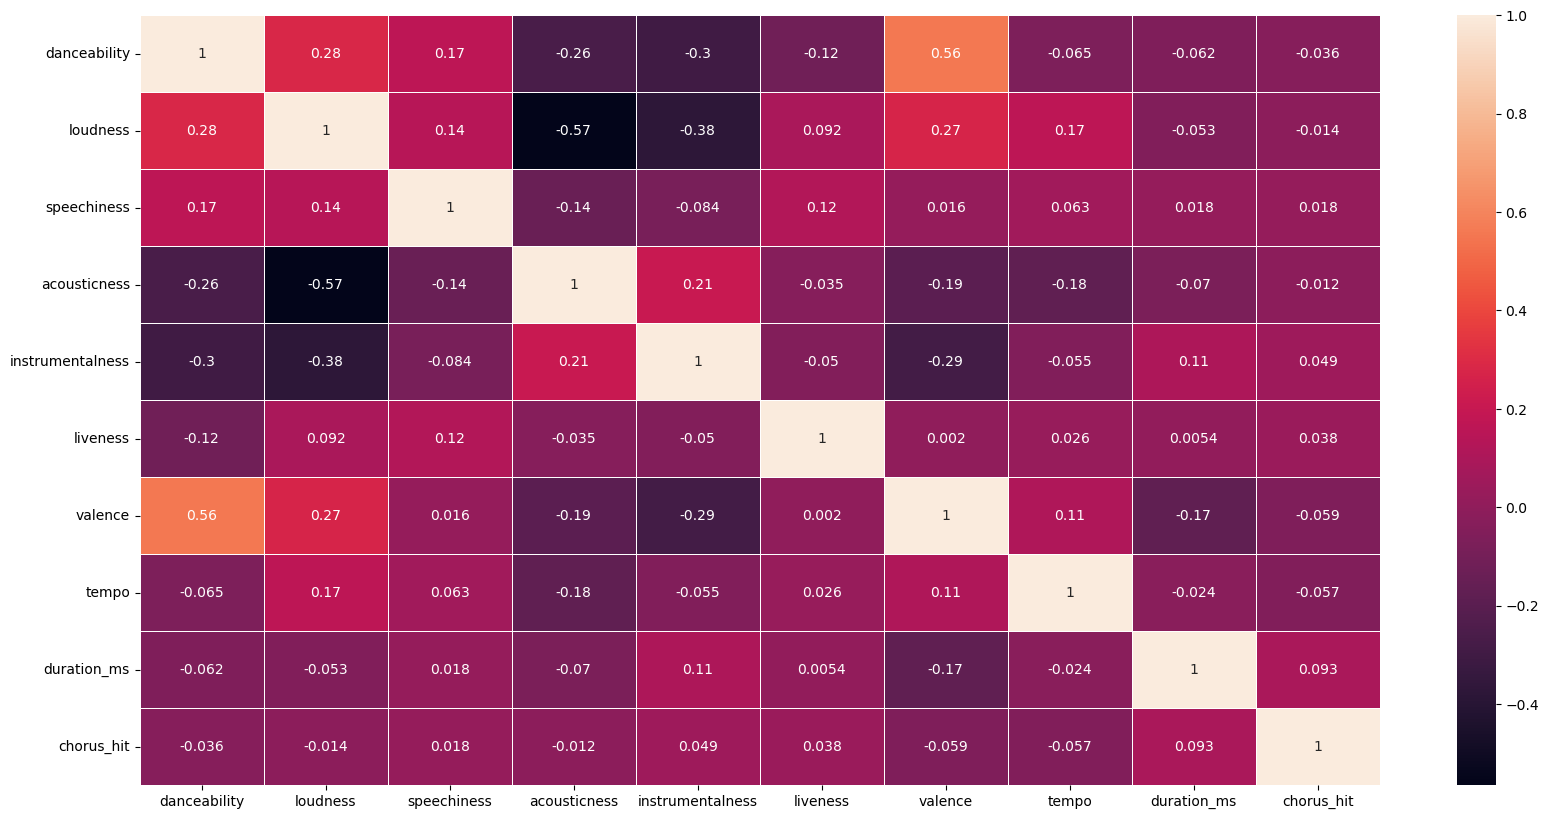

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
dataplot = sns.heatmap(X_ohe[numerical_columns].corr(), annot=True, linewidths=0.5, ax=ax)

<br><b>Split Train-Test Data</b><br>
Since our dataset is large we can afford ourselves to use less than 20% of the data as test:

In [ ]:
x_train_raw, x_test_raw, y_train, y_test = train_test_split(X_ohe,y, train_size = 0.85, random_state=0)
print(f"Train DataSet: {x_train_raw.shape[0]} with {x_train_raw.shape[1]} features")
print(f"Test DataSet: {x_test_raw.shape[0]} with {x_test_raw.shape[1]} features")

Train DataSet: 34820 with 34 features
Test DataSet: 6145 with 34 features


<br><b>Scaling</b><br>
We will scale on the training dataset then apply it to both train and test.

In [ ]:
# We will scale on the training dataset then apply it to both train and test
scalar = StandardScaler(copy=True, with_mean=True, with_std=True).fit(x_train_raw[numerical_columns])

train_scaled = pd.DataFrame(scalar.transform(x_train_raw[numerical_columns]),columns=numerical_columns)
test_scaled = pd.DataFrame(scalar.transform(x_test_raw[numerical_columns]),columns=numerical_columns)

x_train_scaled = x_train_raw.reset_index(drop=True)
x_test_scaled = x_test_raw.reset_index(drop=True)

for col in numerical_columns:
    x_train_scaled[col] = train_scaled[col].reset_index(drop=True)
    x_test_scaled[col] = test_scaled[col].reset_index(drop=True)
    
x_train_scaled.head(5)

,mode,danceability,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,...,time_signature_1,time_signature_3,time_signature_4,time_signature_5,decade_1960,decade_1970,decade_1980,decade_1990,decade_2000,decade_2010
0,0,0.659797,0.671334,-0.444326,-0.056395,-0.510138,-0.448698,-0.231997,-0.669737,-0.567695,...,0,0,1,0,0,0,0,0,0,1
1,1,-0.948715,0.542885,-0.582836,0.605874,-0.510203,-0.321139,-1.024625,0.447495,-0.300113,...,0,0,1,0,0,1,0,0,0,0
2,0,1.497798,0.661511,1.175285,-0.932127,-0.510204,-0.671925,1.125191,-1.003635,-0.186813,...,0,0,1,0,0,0,0,1,0,0
3,1,-0.571896,-1.459407,-0.475868,1.002053,2.386606,-0.710772,0.414817,1.007657,0.805898,...,0,0,1,0,0,1,0,0,0,0
4,1,-0.768742,0.221951,-0.378499,-1.023485,-0.510179,0.490595,-0.437632,-0.203159,-0.507298,...,0,0,1,0,0,0,0,1,0,0


In [ ]:
x_train_scaled.describe().round(3)

,mode,danceability,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,...,time_signature_1,time_signature_3,time_signature_4,time_signature_5,decade_1960,decade_1970,decade_1980,decade_1990,decade_2000,decade_2010
count,34820.000,34820.000,34820.000,34820.000,34820.000,34820.000,34820.000,34820.000,34820.000,34820.000,...,34820.000,34820.000,34820.000,34820.000,34820.000,34820.000,34820.000,34820.000,34820.000,34820.000
mean,0.693,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,...,0.009,0.092,0.885,0.014,0.209,0.190,0.168,0.135,0.142,0.157
std,0.461,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,...,0.094,0.289,0.319,0.116,0.406,0.392,0.374,0.341,0.349,0.363
min,0.000,-3.030,-7.381,-0.964,-1.070,-0.510,-1.089,-2.030,-4.103,-1.839,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.000,-0.673,-0.485,-0.502,-0.955,-0.510,-0.621,-0.797,-0.759,-0.518,...,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,1.000,0.069,0.180,-0.369,-0.314,-0.510,-0.402,0.060,-0.062,-0.142,...,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,1.000,0.727,0.723,-0.012,0.913,-0.303,0.346,0.845,0.591,0.268,...,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
max,1.000,2.527,2.630,8.087,1.874,2.782,4.625,1.693,4.177,32.947,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


<br><b>Optional Additional Work</b><br>
There are several other data preprocessing methods that we will consider adding to our dataset for our final submission which could enhance our model's performance, such as:<br>
1. PCA - Find clusters in the dataset and use these as features<br>
2. Scraper for Spotify - Will allow us to extract additional feature related to each track such as:<br>
* Artist's gender<br>
* Semantic of bio<br>
* etc. <br><br>

By adding these additional features, we might find interesting correlations, learn the secret to creating a great song. <br>
Goodbye Harvard, hello Hollywood!


<br><b>Model Exploring</b><br>

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier


In [ ]:
dict_of_models = {'LogisticRegression':LogisticRegression(),
                  'DecisionTreeClassifier':DecisionTreeClassifier(), 
                 'KNeighborsClassifier':KNeighborsClassifier()
                 }


In [ ]:
parametersOfValue = {
    'n_neighbors':[2,4,8,15,30, 50, 100],
    'n_estimators':[50,100,500],
    'max_depth':[1,2,5,10,20,50],
    'learning_rate':[1,0.1,0.01,0.001,0.0001],
    'random_state':[1],
    'penalty':['l1','l2'],
    'solver':['saga'],
    'alpha':[1,0.1,0.01,0.001,0.0001],
    'C':[1,0.1,0.01,0.001,0.0001]
}

<br><b>Hyper Parameter Fuction:</b><br>
The function is the main heart of the project and its build from layers:<br>
* Main layer - Receives the list of Classifiers + Parameters, and iterated through the classifiers
* Internal layer - Recives each classifiers, and calulate the scores for all its parameter combinations using:<br>
* 3rd layer - Generates a list of all possible parameter combination for a classifier by comparing it's supported parameters to the parameterofValue list.
* 4th layer - Does the actual combination dictionary

<br><b>Layer 4:</b><br>
Convert hyper-parameter list into a combination dict:

In [ ]:
import itertools
def convertDictIntoCombinationDict(classifierName,parametersOfValue):
    prop_combinations = list(itertools.product(*(parametersOfValue[Name] for Name in parametersOfValue)))
    combinationsDict ={}
    for i,item in enumerate(prop_combinations):
        modelTempName = "%s_%s"%(classifierName,i)
        #print(modelTempName)
        combinationsDict[modelTempName]={'model_type':classifierName}
        for j,colName in enumerate(parametersOfValue.keys()):
            combinationsDict[modelTempName][colName]=item[j]
    
    
    return combinationsDict



### --------------------------------------------------------------------------------------------------------------------###
#Example run:

combinationsDict = convertDictIntoCombinationDict('TestClassifier',parametersOfValue)
combinationsDict = pd.DataFrame(combinationsDict).T
combinationsDict.head(10)

,model_type,n_neighbors,n_estimators,max_depth,learning_rate,random_state,penalty,solver,alpha,C
TestClassifier_0,TestClassifier,2,50,1,1,1,l1,saga,1,1
TestClassifier_1,TestClassifier,2,50,1,1,1,l1,saga,1,0.1
TestClassifier_2,TestClassifier,2,50,1,1,1,l1,saga,1,0.01
TestClassifier_3,TestClassifier,2,50,1,1,1,l1,saga,1,0.001
TestClassifier_4,TestClassifier,2,50,1,1,1,l1,saga,1,0.0001
TestClassifier_5,TestClassifier,2,50,1,1,1,l1,saga,0.1,1
TestClassifier_6,TestClassifier,2,50,1,1,1,l1,saga,0.1,0.1
TestClassifier_7,TestClassifier,2,50,1,1,1,l1,saga,0.1,0.01
TestClassifier_8,TestClassifier,2,50,1,1,1,l1,saga,0.1,0.001
TestClassifier_9,TestClassifier,2,50,1,1,1,l1,saga,0.1,0.0001


<br><b>Layer 3:</b><br>
This function received the values lists only for the relevant parameters and returns a list of all different hyper-parameter combinations for this classifier

In [ ]:
def getAllParameterCombinationForClassifier(classifierName,classifierModel,parametersOfValue):

    paramList = classifierModel.get_params()


    classifierParametsOfValue = {}
    for param in paramList:
        if param in parametersOfValue.keys():
            classifierParametsOfValue[param]=parametersOfValue[param]

    #print(classifierName)
    #print(classifierParametsOfValue.keys())

    combinationsDict_ForModel = convertDictIntoCombinationDict(classifierName,classifierParametsOfValue)

    relevantParametersForModel = combinationsDict_ForModel[list(combinationsDict_ForModel.keys())[0]].keys()
    print('Beginning training %s - %s combinations'%(classifierName,len(combinationsDict_ForModel)))
    
    return combinationsDict_ForModel


### --------------------------------------------------------------------------------------------------------------------###
#Example run:


classifierName,classifierModel = ('LogisticRegression',LogisticRegression())
combinationsDict_ForModel = getAllParameterCombinationForClassifier(classifierName,classifierModel,parametersOfValue=parametersOfValue)
#pd.DataFrame(combinationsDict_ForModel).T.head(10)

Beginning training LogisticRegression - 10 combinations


In [ ]:
all_model_combinations = {}

for classifierName,classifierModel in dict_of_models.items():
    #print(classifierName,classifierModel)
    combinationsDict_ForModel = getAllParameterCombinationForClassifier(classifierName,classifierModel,parametersOfValue=parametersOfValue)
    #print(combinationsDict_ForModel)
    all_model_combinations.update(combinationsDict_ForModel)

all_model_combinations_df = pd.DataFrame(all_model_combinations).T

Beginning training LogisticRegression - 10 combinations
Beginning training DecisionTreeClassifier - 6 combinations
Beginning training KNeighborsClassifier - 7 combinations


In [ ]:
print(f'There are {all_model_combinations_df.shape[0]} different model combinations for us to test')
all_model_combinations_df

There are 23 different model combinations for us to test


,model_type,C,penalty,random_state,solver,max_depth,n_neighbors
LogisticRegression_0,LogisticRegression,1,l1,1,saga,NaN,NaN
LogisticRegression_1,LogisticRegression,1,l2,1,saga,NaN,NaN
LogisticRegression_2,LogisticRegression,0.1,l1,1,saga,NaN,NaN
LogisticRegression_3,LogisticRegression,0.1,l2,1,saga,NaN,NaN
LogisticRegression_4,LogisticRegression,0.01,l1,1,saga,NaN,NaN
LogisticRegression_5,LogisticRegression,0.01,l2,1,saga,NaN,NaN
LogisticRegression_6,LogisticRegression,0.001,l1,1,saga,NaN,NaN
LogisticRegression_7,LogisticRegression,0.001,l2,1,saga,NaN,NaN
LogisticRegression_8,LogisticRegression,0.0001,l1,1,saga,NaN,NaN
LogisticRegression_9,LogisticRegression,0.0001,l2,1,saga,NaN,NaN


<br><b>Cross Validation:</b><br>
Iterate over our list of model instructions, create and fit each of the models and cross-validate it

In [ ]:
from timeit import default_timer as timer

dict_of_fitted_models = {}

for i,model_row in enumerate(all_model_combinations_df.T.items()):
    
    start = timer()
    
    # Take existing model and set it hyper parameters based on instructions:
    model_name = model_row[0]
    model_type = model_row[1][0]
    classifierModel = clone(dict_of_models[model_type])
    model_props = classifierModel.get_params()
    
    model_properties_instructions = model_row[1][1:]
     
    
    for prop_instruction in model_properties_instructions.index:
        if (prop_instruction in list(model_props.keys())):
            model_props[prop_instruction]=model_properties_instructions[prop_instruction]
            
    classifierModel.set_params(**model_props)
    
    #print(f"Model Name: {model_name} - {classifierModel}")
    
    cross_val = cross_validate(classifierModel, x_train_scaled, y_train, cv=3, scoring='accuracy', return_train_score=True)
    
    train_score = np.mean(cross_val['train_score'])
    val_score = np.mean(cross_val['test_score'])    
    
    # Fit on entire training data
    classifierModel.fit(x_train_scaled, y_train)
    test_score = classifierModel.score(x_test_scaled,y_test)
    
    all_model_combinations_df.at[model_name,'train_score']=train_score
    all_model_combinations_df.at[model_name,'val_score']=val_score
    all_model_combinations_df.at[model_name,'test_score']=test_score
    
    yhat= classifierModel.predict_proba(x_test_scaled)[:,1]
    
    fpr, tpr, thresholds = roc_curve(y_test, yhat)
    auc_result = auc(fpr,tpr)
    all_model_combinations_df.at[model_name,'auc_result']=auc_result
    
    
    all_model_combinations_df.at[model_name,'train_size']=x_train_scaled.shape[0]
    all_model_combinations_df.at[model_name,'test_size']=x_test_scaled.shape[0]
    all_model_combinations_df.at[model_name,'feature_n']=x_test_scaled.shape[1]
        
    
    end = timer()
    run_time_secs = round(end - start,4)
    all_model_combinations_df.at[model_name,'run_time']=run_time_secs
    
    all_model_combinations_df.at[model_name,'trained_model']=classifierModel
    dict_of_fitted_models[model_name] = classifierModel
    
    print(f"Model Name: {model_name} - {classifierModel} - val_score: {round(val_score,3)}.")

    #model_row['traingSize']=x_train_scaled.shape[0]
    #model_row['test_size']=x_test_scaled.shape[0]
    
    
print("Finished Run")

Model Name: LogisticRegression_0 - LogisticRegression(C=1, penalty='l1', random_state=1, solver='saga') - val_score: 0.737.
Model Name: LogisticRegression_1 - LogisticRegression(C=1, random_state=1, solver='saga') - val_score: 0.737.
Model Name: LogisticRegression_2 - LogisticRegression(C=0.1, penalty='l1', random_state=1, solver='saga') - val_score: 0.737.
Model Name: LogisticRegression_3 - LogisticRegression(C=0.1, random_state=1, solver='saga') - val_score: 0.737.
Model Name: LogisticRegression_4 - LogisticRegression(C=0.01, penalty='l1', random_state=1, solver='saga') - val_score: 0.731.
Model Name: LogisticRegression_5 - LogisticRegression(C=0.01, random_state=1, solver='saga') - val_score: 0.735.
Model Name: LogisticRegression_6 - LogisticRegression(C=0.001, penalty='l1', random_state=1, solver='saga') - val_score: 0.71.
Model Name: LogisticRegression_7 - LogisticRegression(C=0.001, random_state=1, solver='saga') - val_score: 0.724.
Model Name: LogisticRegression_8 - LogisticRegr

In [ ]:
print(f"All model and their scores sorted by name")
all_model_combinations_df

All model and their scores sorted by name


,model_type,C,penalty,random_state,solver,max_depth,n_neighbors,train_score,val_score,test_score,auc_result,train_size,test_size,run_time,trained_model
LogisticRegression_0,LogisticRegression,1,l1,1,saga,NaN,NaN,0.738886,0.737163,0.729373,0.803975,34820.0,6145.0,8.3828,"LogisticRegression(C=1, penalty='l1', random_s..."
LogisticRegression_1,LogisticRegression,1,l2,1,saga,NaN,NaN,0.738728,0.737220,0.729536,0.803970,34820.0,6145.0,6.4522,"LogisticRegression(C=1, random_state=1, solver..."
LogisticRegression_2,LogisticRegression,0.1,l1,1,saga,NaN,NaN,0.738067,0.736502,0.729211,0.804060,34820.0,6145.0,5.4601,"LogisticRegression(C=0.1, penalty='l1', random..."
LogisticRegression_3,LogisticRegression,0.1,l2,1,saga,NaN,NaN,0.738613,0.737048,0.729048,0.804022,34820.0,6145.0,6.4637,"LogisticRegression(C=0.1, random_state=1, solv..."
LogisticRegression_4,LogisticRegression,0.01,l1,1,saga,NaN,NaN,0.731505,0.730758,0.730513,0.801082,34820.0,6145.0,1.5177,"LogisticRegression(C=0.01, penalty='l1', rando..."
LogisticRegression_5,LogisticRegression,0.01,l2,1,saga,NaN,NaN,0.736028,0.734980,0.729699,0.803961,34820.0,6145.0,3.6324,"LogisticRegression(C=0.01, random_state=1, sol..."
LogisticRegression_6,LogisticRegression,0.001,l1,1,saga,NaN,NaN,0.710569,0.709908,0.714239,0.787602,34820.0,6145.0,1.3105,"LogisticRegression(C=0.001, penalty='l1', rand..."
LogisticRegression_7,LogisticRegression,0.001,l2,1,saga,NaN,NaN,0.725546,0.724297,0.724980,0.798764,34820.0,6145.0,1.0941,"LogisticRegression(C=0.001, random_state=1, so..."
LogisticRegression_8,LogisticRegression,0.0001,l1,1,saga,NaN,NaN,0.500230,0.500230,0.508544,0.500000,34820.0,6145.0,0.4520,"LogisticRegression(C=0.0001, penalty='l1', ran..."
LogisticRegression_9,LogisticRegression,0.0001,l2,1,saga,NaN,NaN,0.711301,0.711315,0.711961,0.784705,34820.0,6145.0,1.0454,"LogisticRegression(C=0.0001, random_state=1, s..."


<br><b>Best Performing model:</b><br>
Since we collected all sort of output scores from our model, we can check and see which model performed best for each category:

"Show off" award:<br>
The award for the model with the best training score:

In [ ]:
print(f"Top 3 performing models based on Validation Score")
all_model_combinations_df.sort_values(by='val_score', ascending=False).head(3)

Top 3 performing models based on Validation Score


,model_type,C,penalty,random_state,solver,max_depth,n_neighbors,train_score,val_score,test_score,auc_result,train_size,test_size,run_time,trained_model
DecisionTreeClassifier_3,DecisionTreeClassifier,NaN,NaN,1,NaN,10,NaN,0.824052,0.758128,0.761595,0.811286,34820.0,6145.0,1.3501,"DecisionTreeClassifier(max_depth=10, random_st..."
KNeighborsClassifier_4,KNeighborsClassifier,NaN,NaN,NaN,NaN,NaN,30,0.767820,0.753360,0.766640,0.842962,34820.0,6145.0,8.8912,KNeighborsClassifier(n_neighbors=30)
KNeighborsClassifier_3,KNeighborsClassifier,NaN,NaN,NaN,NaN,NaN,15,0.779667,0.751264,0.760618,0.834621,34820.0,6145.0,8.7293,KNeighborsClassifier(n_neighbors=15)


Accuracy award:<br>
The award for best overall test score model (Based on proportion of correct predictions made by the classifier)

In [ ]:
print(f"Top 3 performing models based on Test Score")
all_model_combinations_df.sort_values(by='test_score', ascending=False).head(3)

Top 3 performing models based on Test Score


,model_type,C,penalty,random_state,solver,max_depth,n_neighbors,train_score,val_score,test_score,auc_result,train_size,test_size,run_time,trained_model
KNeighborsClassifier_4,KNeighborsClassifier,NaN,NaN,NaN,NaN,NaN,30,0.767820,0.753360,0.766640,0.842962,34820.0,6145.0,8.8912,KNeighborsClassifier(n_neighbors=30)
DecisionTreeClassifier_3,DecisionTreeClassifier,NaN,NaN,1,NaN,10,NaN,0.824052,0.758128,0.761595,0.811286,34820.0,6145.0,1.3501,"DecisionTreeClassifier(max_depth=10, random_st..."
KNeighborsClassifier_3,KNeighborsClassifier,NaN,NaN,NaN,NaN,NaN,15,0.779667,0.751264,0.760618,0.834621,34820.0,6145.0,8.7293,KNeighborsClassifier(n_neighbors=15)


AUC award:<br>
The award for the model best able to distinguish between the two classes by plotting the true positive rate (TPR) against the false positive rate (FPR) at different classification thresholds and calculating the area under their curve

In [ ]:
print(f"Top 3 performing models based on AUC Score")
all_model_combinations_df.sort_values(by='auc_result', ascending=False).head(3)

Top 3 performing models based on AUC Score


,model_type,C,penalty,random_state,solver,max_depth,n_neighbors,train_score,val_score,test_score,auc_result,train_size,test_size,run_time,trained_model
KNeighborsClassifier_6,KNeighborsClassifier,NaN,NaN,NaN,NaN,NaN,100,0.746511,0.742188,0.754434,0.843973,34820.0,6145.0,10.4342,KNeighborsClassifier(n_neighbors=100)
KNeighborsClassifier_5,KNeighborsClassifier,NaN,NaN,NaN,NaN,NaN,50,0.758127,0.748794,0.758340,0.843491,34820.0,6145.0,9.3461,KNeighborsClassifier(n_neighbors=50)
KNeighborsClassifier_4,KNeighborsClassifier,NaN,NaN,NaN,NaN,NaN,30,0.767820,0.753360,0.766640,0.842962,34820.0,6145.0,8.8912,KNeighborsClassifier(n_neighbors=30)


<br><b>ROC Curve:</b><br>
We will now plot the ratio between true positive rate (TPR) against the false positive rate (FPR) at different classification thresholds for the best performing model of each classifier type.

In [ ]:
def plot_roc_curve(model,X,Y, model_name="Classification Model"):
    
    # Plot the ROC curve
    yhat= model.predict_proba(X)[:,1]

    fpr, tpr, thresholds = roc_curve(Y, yhat)
    auc_result = auc(fpr,tpr)

    x=np.arange(0,100)/100
    ax.plot(x,x,'--',color="gray",alpha=0.3)
    ax.plot(fpr,tpr,label=model_name)
    ax.set_ylabel("True Positive Rate")
    ax.set_xlabel("False Positive Rate")
    ax.set_title(f"ROC Curve for top performing models.")
    ax.legend()
    ax.plot()

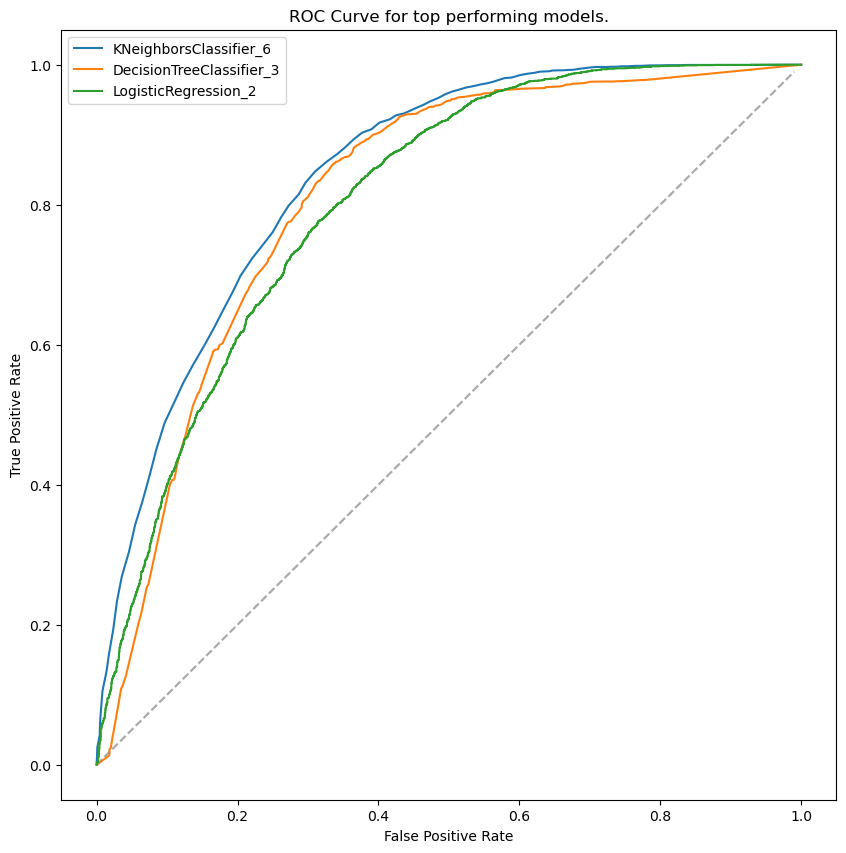

In [ ]:
list_of_unique_model_types = list(dict_of_models.keys())
col_size = 2

fig, ax = plt.subplots(1,1, figsize=(10,10))

for i, item in enumerate(all_model_combinations_df.sort_values(by='auc_result', ascending=False).T.items()):
    model_name = item[0]
    model_record = item[1]
    model_type = model_record['model_type']
    
    if model_type in list_of_unique_model_types:
        trained_model = model_record['trained_model'].fit(x_train_scaled,y_train)
    
        plot_roc_curve(trained_model,x_test_scaled,y_test,model_name=model_name)
        
        list_of_unique_model_types.remove(model_type)
    

In [ ]:
best_performing_model = all_model_combinations_df.sort_values(by='auc_result', ascending=False).head(1)
best_model = best_performing_model['trained_model'][0].fit(x_train_scaled,y_train)
print(f"Our best performing model so far is {best_model} --> {round(best_performing_model['auc_result'][0],3)} AUC score")

Our best performing model so far is KNeighborsClassifier(n_neighbors=100) --> 0.844 AUC score


<br><b>Feature importance:</b><br>
Since KNeighborsClassifier doesn't provide a clear way to calculate feature importance, we will go to the 2nd best modele which isn't KNeighborsClassifier to get this information from

In [ ]:
second_best_performing_model = all_model_combinations_df[all_model_combinations_df['model_type']!="KNeighborsClassifier"].sort_values(by='auc_result', ascending=False).head(1)
second_best_model = second_best_performing_model['trained_model'][0].fit(x_train_scaled,y_train)
print(f"Our best performing model so far is {second_best_model} --> {round(second_best_performing_model['auc_result'][0],3)} AUC score")

Our best performing model so far is DecisionTreeClassifier(max_depth=10, random_state=1) --> 0.811 AUC score


In [ ]:
x_df = x_train_scaled.copy()
x_df = x_df.reset_index()
_y_train = y_train.reset_index(drop=True)
x_df['y'] = _y_train

n = x_df.shape[0]
result_list = []
coef_list = {col:[] for col in x_train_scaled.columns}

bar = progressbar.ProgressBar(maxval=100, widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
bar.start()
for i in range(100):
    #Take a random sample from the df:
    x_df_sample = x_df.sample(n=n,replace=True)
    
    # Split the df into x and y
    y_ = x_df_sample['y']
    x_ = x_df_sample.copy().drop('y', axis=1)
    
    # Initialize a Linear Regression object with fit_intercept as False
    model = second_best_model
    
    model.fit(x_,y_)
    
    # Extract the coefficients from the trained model and store them in a list
    coefficients = model.feature_importances_
    
    for i,coef_name in enumerate(x_train_scaled.columns):
        coef_value = coefficients[i]
        coef_list[coef_name].append(coef_value)
        
    bar.update(i)
        
coef_df = pd.DataFrame(coef_list)

In [ ]:
coef_df = pd.DataFrame(coef_list)
coef_df.head(10)

,mode,danceability,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,...,time_signature_1,time_signature_3,time_signature_4,time_signature_5,decade_1960,decade_1970,decade_1980,decade_1990,decade_2000,decade_2010
0,0.009987,0.010944,0.107986,0.038263,0.075327,0.164785,0.380413,0.020297,0.025236,0.022955,...,0.0,0.000000,0.000486,0.000542,0.000000,0.020847,0.010907,0.001973,0.006287,0.004283
1,0.016096,0.008114,0.119718,0.027674,0.064237,0.154812,0.375152,0.018435,0.034101,0.024493,...,0.0,0.000000,0.003486,0.000969,0.000601,0.026204,0.009319,0.000757,0.007203,0.001384
2,0.010841,0.010574,0.122392,0.038062,0.058513,0.150591,0.404347,0.020506,0.033483,0.019088,...,0.0,0.000000,0.001797,0.003257,0.000000,0.022198,0.009626,0.001029,0.002781,0.001113
3,0.008041,0.010160,0.119182,0.037140,0.075499,0.129174,0.395470,0.016017,0.045220,0.026875,...,0.0,0.000202,0.001486,0.000110,0.000000,0.024547,0.005512,0.001757,0.003112,0.003427
4,0.015040,0.009741,0.128505,0.033682,0.080039,0.126743,0.385545,0.017575,0.043054,0.018304,...,0.0,0.000294,0.000669,0.000165,0.000374,0.016185,0.006925,0.002894,0.011774,0.004802
5,0.026156,0.011555,0.108188,0.028185,0.065678,0.153062,0.381282,0.021205,0.037291,0.021432,...,0.0,0.000000,0.000406,0.000000,0.001032,0.022324,0.009974,0.002838,0.005741,0.003272
6,0.012710,0.010361,0.110984,0.026396,0.069736,0.161999,0.404026,0.015085,0.026998,0.028883,...,0.0,0.000000,0.000551,0.003110,0.002427,0.016660,0.002540,0.003133,0.005164,0.003493
7,0.014016,0.007588,0.125661,0.031507,0.078696,0.138708,0.391669,0.018515,0.029759,0.020422,...,0.0,0.000600,0.000465,0.000990,0.000208,0.017178,0.009613,0.008051,0.003549,0.005040
8,0.010011,0.008381,0.121425,0.030896,0.078408,0.119431,0.397362,0.019990,0.037340,0.030588,...,0.0,0.000793,0.001213,0.000147,0.003014,0.016036,0.007494,0.004877,0.007684,0.005294
9,0.017556,0.008752,0.111481,0.035591,0.076131,0.154042,0.392895,0.017244,0.029969,0.027067,...,0.0,0.000342,0.000378,0.000190,0.000851,0.018810,0.005549,0.001805,0.003766,0.000000


In [ ]:
# Create a dict for each coef containnig the 95% confidence interval
coef_info = {}

features_to_keep = []

for feature, coef in coef_df.items():
    conf_int = np.percentile(coef,[2.5,97.5])
    coef_info[feature]=conf_int
    
    if not (conf_int[0]<=0 and conf_int[0]>=0): 
        features_to_keep.append(feature)
    
    print(f"For coef {feature} the low 5% is {round(conf_int[0],3)} and the high 95% is {round(conf_int[1],3)}")

For coef mode the low 5% is 0.009 and the high 95% is 0.022
For coef danceability the low 5% is 0.006 and the high 95% is 0.014
For coef loudness the low 5% is 0.092 and the high 95% is 0.129
For coef speechiness the low 5% is 0.024 and the high 95% is 0.042
For coef acousticness the low 5% is 0.06 and the high 95% is 0.09
For coef instrumentalness the low 5% is 0.119 and the high 95% is 0.165
For coef liveness the low 5% is 0.37 and the high 95% is 0.408
For coef valence the low 5% is 0.011 and the high 95% is 0.024
For coef tempo the low 5% is 0.025 and the high 95% is 0.059
For coef duration_ms the low 5% is 0.015 and the high 95% is 0.031
For coef chorus_hit the low 5% is 0.054 and the high 95% is 0.074
For coef key_0 the low 5% is 0.011 and the high 95% is 0.023
For coef key_1 the low 5% is 0.0 and the high 95% is 0.003
For coef key_2 the low 5% is 0.0 and the high 95% is 0.003
For coef key_3 the low 5% is 0.0 and the high 95% is 0.003
For coef key_4 the low 5% is 0.0 and the high

In [ ]:
print(f"{len(features_to_keep)} features to keep: {features_to_keep}")

19 features to keep: ['mode', 'danceability', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'chorus_hit', 'key_0', 'key_1', 'key_2', 'key_5', 'decade_1970', 'decade_1980', 'decade_1990', 'decade_2000']


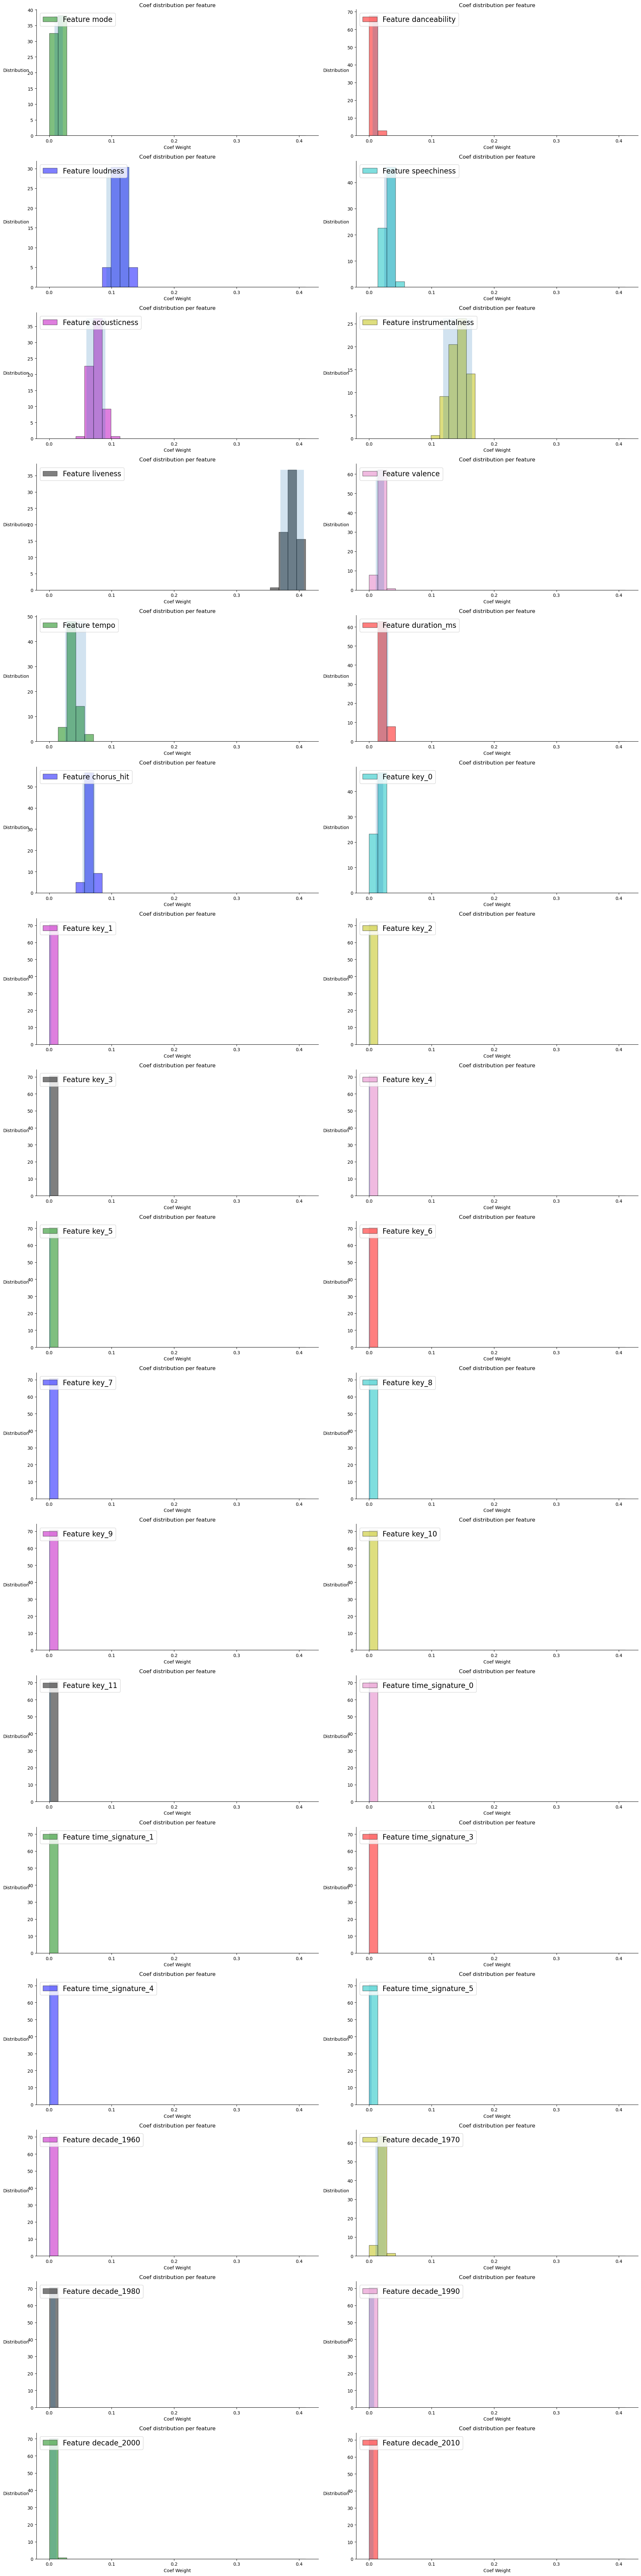

In [ ]:
# Plot all the coefficients histogram seperatly

import math

coeff_num = coef_df.shape[1]
row_num = math.ceil(coeff_num/2)
bin_start = min(coef_df.min())
bin_end = max(coef_df.max())

fig = plt.gcf()
fig.set_size_inches(20,80)
bins = np.linspace(bin_start, bin_end, 30)
c_list = ['g','r','b','c','m','y','k','tab:pink','g','r','b','c','m','y','k','tab:pink','g','r','b','c','m','y','k','tab:pink','g','r','b','c','m','y','k','tab:pink','g','r','b','c','m','y','k','tab:pink']


for i,(coef,values) in enumerate(coef_df.items()):
    
    ax = fig.add_subplot(row_num,2,i+1)
    height, bins, patches = ax.hist(values, bins, alpha=0.5, label=f"Feature {coef}",density=True,edgecolor='k', color=c_list[i])
    ax.fill_betweenx([0, height.max()], coef_info[coef][0], coef_info[coef][1], alpha=0.2)
    ax.legend(loc='upper left',fontsize=16)
    ax.set_xlabel('Coef Weight')
    ax.set_ylabel('Distribution',rotation=0,labelpad=25)
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title('Coef distribution per feature')
    i+=1

plt.tight_layout()
plt.plot;

We will now attempt to re-train the same model on the significant features only

In [ ]:
model_name = 'best_classifier_thin'
classifierModel = clone(second_best_model)

start = timer()

cross_val = cross_validate(classifierModel, x_train_scaled, y_train, cv=3, scoring='accuracy', return_train_score=True)
    
train_score = np.mean(cross_val['train_score'])
val_score = np.mean(cross_val['test_score'])    

# Fit on entire training data
classifierModel.fit(x_train_scaled, y_train)
test_score = classifierModel.score(x_test_scaled,y_test)

all_model_combinations_df.at[model_name,'train_score']=train_score
all_model_combinations_df.at[model_name,'val_score']=val_score
all_model_combinations_df.at[model_name,'test_score']=test_score

yhat= classifierModel.predict_proba(x_test_scaled)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, yhat)
auc_result = auc(fpr,tpr)
all_model_combinations_df.at[model_name,'auc_result']=auc_result


all_model_combinations_df.at[model_name,'train_size']=x_train_scaled.shape[0]
all_model_combinations_df.at[model_name,'test_size']=x_test_scaled.shape[0]
all_model_combinations_df.at[model_name,'feature_n']=x_test_scaled.shape[1]


end = timer()
run_time_secs = round(end - start,4)
all_model_combinations_df.at[model_name,'run_time']=run_time_secs

all_model_combinations_df.at[model_name,'trained_model']=classifierModel

print(f"{model_name} - Val: {round(val_score,3)}, Test: {round(test_score,3)}, AUC: {round(auc_result,3)}")

best_classifier_thin - Val: 0.758, Test: 0.762, AUC: 0.811


In [ ]:
all_model_combinations_df.sort_values(by='auc_result', ascending=False).head(10)

,model_type,C,penalty,random_state,solver,max_depth,n_neighbors,train_score,val_score,test_score,auc_result,train_size,test_size,run_time,trained_model,feature_n
KNeighborsClassifier_6,KNeighborsClassifier,NaN,NaN,NaN,NaN,NaN,100,0.746511,0.742188,0.754434,0.843973,34820.0,6145.0,10.4342,KNeighborsClassifier(n_neighbors=100),NaN
KNeighborsClassifier_5,KNeighborsClassifier,NaN,NaN,NaN,NaN,NaN,50,0.758127,0.748794,0.758340,0.843491,34820.0,6145.0,9.3461,KNeighborsClassifier(n_neighbors=50),NaN
KNeighborsClassifier_4,KNeighborsClassifier,NaN,NaN,NaN,NaN,NaN,30,0.767820,0.753360,0.766640,0.842962,34820.0,6145.0,8.8912,KNeighborsClassifier(n_neighbors=30),NaN
KNeighborsClassifier_3,KNeighborsClassifier,NaN,NaN,NaN,NaN,NaN,15,0.779667,0.751264,0.760618,0.834621,34820.0,6145.0,8.7293,KNeighborsClassifier(n_neighbors=15),NaN
KNeighborsClassifier_2,KNeighborsClassifier,NaN,NaN,NaN,NaN,NaN,8,0.807596,0.748162,0.750203,0.821007,34820.0,6145.0,8.6657,KNeighborsClassifier(n_neighbors=8),NaN
best_classifier_thin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.824052,0.758128,0.761595,0.811286,34820.0,6145.0,1.3865,"DecisionTreeClassifier(max_depth=10, random_st...",34.0
DecisionTreeClassifier_3,DecisionTreeClassifier,NaN,NaN,1,NaN,10,NaN,0.824052,0.758128,0.761595,0.811286,34820.0,6145.0,1.3501,"DecisionTreeClassifier(max_depth=10, random_st...",NaN
DecisionTreeClassifier_2,DecisionTreeClassifier,NaN,NaN,1,NaN,5,NaN,0.751292,0.744285,0.745810,0.806713,34820.0,6145.0,0.7659,"DecisionTreeClassifier(max_depth=5, random_sta...",NaN
LogisticRegression_2,LogisticRegression,0.1,l1,1,saga,NaN,NaN,0.738067,0.736502,0.729211,0.804060,34820.0,6145.0,5.4601,"LogisticRegression(C=0.1, penalty='l1', random...",NaN
LogisticRegression_3,LogisticRegression,0.1,l2,1,saga,NaN,NaN,0.738613,0.737048,0.729048,0.804022,34820.0,6145.0,6.4637,"LogisticRegression(C=0.1, random_state=1, solv...",NaN


<br><b>Boosting:</b><br>
We'll take a DecisionTreeClassifier with low dept (low complexity) and run it multiple times

In [ ]:
# Define start parameters
n_estimators=1000
random_state=1
simple_dept = 3
learning_rate=0.01

In [ ]:
base_estimator_simple = DecisionTreeClassifier(max_depth=simple_dept, random_state=random_state)

boosing_model = AdaBoostClassifier(base_estimator=base_estimator_simple,
                                   n_estimators=n_estimators, 
                                   random_state=random_state,
                                   learning_rate=learning_rate)
boosing_model.fit(x_train_scaled,y_train)

In [ ]:
boosing_model_train_score = boosing_model.score(x_train_scaled,y_train)
boosing_model_test_score = boosing_model.score(x_test_scaled,y_test)

In [ ]:
print(f"Model: {boosing_model}. Train Score: {round(boosing_model_train_score,4)}. Test Score: {round(boosing_model_test_score,4)}")

In [ ]:
staged_score_train = list(boosing_model.staged_score(x_train_scaled,y_train))
staged_score_val = list(boosing_model.staged_score(x_test_scaled,y_test))

In [ ]:
# your code here
fig = plt.figure(figsize=(16,8))

ax1 = fig.add_subplot(1,1,1)

# Plot the training error with labels
ax1.plot(range(n_estimators), staged_score_train, label = f'staged_score_train', linewidth=1, alpha=1)
ax1.plot(range(n_estimators), staged_score_val, label = f'staged_score_test', linewidth=1, alpha=1)

# Set the plot labels and legends
ax1.set_xlabel('estimator_num', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title(f"Boosing Accuracy for model:\n {boosing_model}",fontsize=9)

plt.ylim([0.6, 0.9])

ax1.legend()

plt.show();

<br><b>Bagging:</b><br>
We'll take a DecisionTreeClassifier with large dept (High variance) and run it multiple times

In [ ]:
n_estimators=500
max_depth=20
random_state=1

In [ ]:


base_estimator = DecisionTreeClassifier(max_depth=max_depth, random_state=random_state)

bagging_model = BaggingClassifier(base_estimator=base_estimator,random_state=random_state,n_estimators=n_estimators)
bagging_model.fit(x_train_scaled,y_train)

In [ ]:
bagging_model_score_train = bagging_model.score(x_train_scaled,y_train)
bagging_model_score_test = bagging_model.score(x_test_scaled,y_test)
print(f"Model: {bagging_model}. Train Score: {round(bagging_model_score_train,4)}. Test Score: {round(bagging_model_score_test,4)}")

<br><b>Bagging feature strength:</b><br>
For regular bagging the top selected feature will always be the same

In [ ]:
col_names = x_train_scaled.columns

top_feature_dict = {col:0 for col in col_names}

for dtree in bagging_model.estimators_:
    top_feature_Id = dtree.tree_.feature[0]
    top_feature_name = col_names[top_feature_Id]
    
    top_feature_dict[top_feature_name]+=1
    
top_predictors_bagging = pd.DataFrame(top_feature_dict, index=["Top Count - Bagging"]).head(1).T
top_predictors_bagging.sort_values(["Top Count - Bagging"], ascending=False).head(10)

<br><b>Random Forest:</b><br>
Same as bagging, only with random feature selection

In [ ]:
random_forest_model = RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,max_features='sqrt', random_state=random_state)
random_forest_model.fit(x_train_scaled,y_train)

In [ ]:
random_forest_train_score = random_forest_model.score(x_train_scaled,y_train)
random_forest_test_score = random_forest_model.score(x_test_scaled,y_test)

In [ ]:
print(f"Model: {random_forest_model}. Train Score: {round(random_forest_train_score,4)}. Test Score: {round(random_forest_test_score,4)}")

<br><b>Random Forest feature selection:</b><br>
Same as bagging, only with random feature selection

In [ ]:
top_feature_dict = {col:0 for col in col_names}

for dtree in random_forest_model.estimators_:
    top_feature_Id = dtree.tree_.feature[0]
    top_feature_name = col_names[top_feature_Id]
    
    top_feature_dict[top_feature_name]+=1
    
top_predictors_bagging = pd.DataFrame(top_feature_dict, index=["Top Count - Random Forest"]).head(1).T
top_predictors_bagging.sort_values(["Top Count - Random Forest"], ascending=False)

In [ ]:
columns_to_run = list(top_predictors_bagging[top_predictors_bagging['Top Count - Random Forest']>35].index)
columns_to_run

In [ ]:
random_forest_model_thin = RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,max_features='sqrt', random_state=random_state)
random_forest_model_thin.fit(x_train_scaled[columns_to_run],y_train)

In [ ]:
random_forest_model_thin_train_score = random_forest_model_thin.score(x_train_scaled[columns_to_run],y_train)
random_forest_model_thin_test_score = random_forest_model_thin.score(x_test_scaled[columns_to_run],y_test)

In [ ]:
print(f"Model: {random_forest_model_thin}. Train Score: {round(random_forest_train_score,4)}. Test Score: {round(random_forest_test_score,4)}")